In [2]:
%matplotlib inline
import os
import csv
import fnmatch
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd


In [3]:
def CharactersTyped(ScratchPad):
    
    NotInclude = ['scratchPadText', '']
    PhraseTypedAll = [item[1] for item in scratchPad]

    IndexNotInclude = [itemInd for itemInd in range(0,len(PhraseTypedAll)) if PhraseTypedAll[itemInd] == '']

    PhrasesTypedEnd = [PhraseTypedAll[item-1] for item in IndexNotInclude if item != 1]

    return len(''.join(PhrasesTypedEnd))

In [27]:
def ComputeDwellTime(TimeDwellChanges, TimeDwellOrig):
    # We need the dwell time and when it changes (index)
    
    TimeDwellNew = TimeDwellOrig
    #TimeDwellChanges = [key for key in userKeys if key[1] in KeyInclude]
    TimeDwellChangeInfo= list()
    pctChangeIndList = list()
    TimeDwellNewList = [TimeDwellOrig]
    #print(TimeDwellChanges)
    indPrev = 0
    flagFirst = 0
    
    for pctChangeInd in range(0, len(TimeDwellChanges)):
        
        if 'DwellTime' in TimeDwellChanges[pctChangeInd][1]:
            
            if float(TimeDwellChanges[pctChangeInd][2]) == 1:
                if 'Increase' in TimeDwellChanges[pctChangeInd][1]:
                    TimeDwellNew = TimeDwellNew + 100
                    TimeDwellNewList.append(TimeDwellNew)
                    pctChangeIndList.append(pctChangeInd)        
                    
                else:
                    TimeDwellNew = TimeDwellNew - 100
                    TimeDwellNewList.append(TimeDwellNew)
                    pctChangeIndList.append(pctChangeInd)
                        
        
        if pctChangeInd == len(TimeDwellChanges)-1:
            pctChangeIndList.append(pctChangeInd)
    
    return [pctChangeIndList]+[TimeDwellNewList]

In [28]:
def TimeOnScratchPad(UserLooksAtKey, TimeDwellChanges):
    
    ScratchPadLookedInd = [ind for ind in range(0,len(UserLooksAtKey)) if 'ScratchPad' in UserLooksAtKey[ind]]
    ScratchPadRow = [UserLooksAtKey[ind] for ind in range(0,len(UserLooksAtKey)) if 'ScratchPad' in UserLooksAtKey[ind]]
    ScratchPadIndDiff = np.diff(np.asarray(ScratchPadLookedInd))

    timeOfLooking = 0
    flagStart = 0
    TimeDwellScratchPad = 0
    ScratchPadInd = 0
    TimeDwellNow = 0
    nScratchPad = 1
    
    for ind1 in range(0, len(ScratchPadIndDiff)):
        if ScratchPadIndDiff[ind1] > 1:
            
            # check if it is the same fixation
            if ScratchPadRow[ind1][2] > ScratchPadRow[ind1+1][2]:
                
                ScratchPadInd = ind1
                # find correct dwell time
                for dwellTimeInd in range(0, len(TimeDwellChanges[0])):
                    if TimeDwellChanges[0][dwellTimeInd] > ScratchPadLookedInd[ind1]:
                        TimeDwellNow = TimeDwellChanges[1][dwellTimeInd]
                        break
                
                if TimeDwellNow == 0:
                    TimeDwellNow = TimeDwellChanges[1][0]
                TimeDwellScratchPad = TimeDwellScratchPad + TimeDwellNow*float(ScratchPadRow[ind1][2])
    
        elif float(ScratchPadRow[ind1][2]) == 0: # sometimes, after looking at the scratchpad, the last look has progress 0
            if ScratchPadIndDiff[ind1-1] == 1:
                nScratchPad = nScratchPad + 1
                    
                ScratchPadInd = ind1
                # find correct dwell time
                for dwellTimeInd in range(0, len(TimeDwellChanges[0])):
                    if TimeDwellChanges[0][dwellTimeInd] > ScratchPadLookedInd[ind1]:
                        TimeDwellNow = TimeDwellChanges[1][dwellTimeInd]
                        break
                
                if TimeDwellNow == 0:
                    TimeDwellNow = TimeDwellChanges[1][0]
                TimeDwellScratchPad = TimeDwellScratchPad + TimeDwellNow*float(ScratchPadRow[ind1][2])
                print(TimeDwellScratchPad)   
    for dwellTimeInd in range(0, len(TimeDwellChanges[0])):
        
        if ScratchPadInd > ScratchPadLookedInd[ind1]:
            TimeDwellNow = TimeDwellChanges[1][dwellTimeInd]
            break
    if TimeDwellNow == 0:
        TimeDwellNow = TimeDwellChanges[1][0]
    
    TimeDwellScratchPad = TimeDwellScratchPad + TimeDwellNow*float(ScratchPadRow[-2][2])        
    #print(TimeDwellScratchPad, ':', TimeDwellNow)
    
    return TimeDwellScratchPad
        

In [29]:
def AddDataToFile(metricComputed, Names, DataEvaluated):

    # Save the data
    fileIn = r'C:\DTU\Data\201805_HealthnRehab\data_summary.csv'

    if Path(fileIn).is_file():
        
        fSize = os.path.getsize(fileIn) # or pd.read_excel(filename) for xls file

        # file exists
        # check if the given column exists
        with open(fileIn, 'r', newline='') as csvfileRead:
            if fSize > 0:
                fileOut = fileIn[:-4] + '1.csv'
                with open(fileOut, 'w', newline='') as csvfileWrite:
                    for row in csv.reader(csvfileRead):
                        if metricComputed in row:
                            # file exists and the metric is present in the file
                            print('This metric is already calculated and saved: ', metricComputed)
                            break
                        else:
                            # file exists but the metric is not present
                            print('adding the metric')
                            filewriter = csv.writer(csvfileWrite, delimiter = ',')
                            if len(row) > 1:
                                rowJoined = list()
                                for rowElement in row:
                                    rowJoined.append(rowElement)
                                
                                
                                print(rowJoined[1])
                                
                                if rowJoined[1] == 'subject_name':
                                    # write the titles of the metrics
                                    rowJoined.append(metricComputed)
                                    filewriter.writerow(rowJoined)
                                else:
                                    #filewriter.writerow([row, str(DataEvaluated[Names.index(row[0])])])
                                    rowJoined.append(str(DataEvaluated[Names.index(row[1])]))
                                    filewriter.writerow(rowJoined)
                                
                            else:
                                if row[1] == 'subject_name':
                                    # write the titles of the metrics
                                    filewriter.writerow([row, metricComputed])
                                else:
                                    filewriter.writerow([row, str(DataEvaluated[Names.index(row[1])])])
            
            
            else:
                fileOut = fileIn
                print('recreating a file')

                with open(fileSave, 'w', newline='') as csvfileWrite:
                    filewriter = csv.writer(csvfileWrite, delimiter=',')
                    filewriter.writerow(['subject_name', metricComputed])
                    for ind in enumerate(Names):
                        filewriter.writerow([Names[ind], DataEvaluated[ind[0]]])
                
    else:
        print('creating a file')
        a = re.compile('(?<=TypingData)(.*)(?=OptiKey)')
        with open(fileSave, 'w', newline='') as csvfileWrite:
            filewriter = csv.writer(csvfileWrite, delimiter=',')
            filewriter.writerow(['subject_name', metricComputed])
            for ind in enumerate(Names):
                subjName = a.findall(Names[ind[0]])
                filewriter.writerow([subjName[0], DataEvaluated[ind[0]]])
     

In [32]:
metricComputed = 'read_text_events_time_ratio'
dataFolderName = r'C:\DTU\Data\201805_HealthnRehab\TypingData'
j = 0
scratchPadToTypingRatioTimeList = list()
Names = list()

for root, dirs, subfolder in os.walk(dataFolderName):

    if not dirs:
        
        #if 'notCompleted' in root or 'notInclude' in root: # Some subjects do not have gaze log and have been marked as 
        
        if 'notCompleted' in root: # Some subjects do not have gaze log and have been marked as 
            #notInclude
            continue
        if 'tb' in root or 'joha' in root:
            continue
            
        scratchPad = None
        userKeys = None
        phraseLog = None
        
        for file in subfolder:
            
            if fnmatch.fnmatch(file, 'ScratchPadLog*'):
                try:
                    fScratchPad = open(root + '\\' + file, encoding='utf-8')
                    readerScratchPad = csv.reader(fScratchPad)
                    scratchPad = list(readerScratchPad)
                except:
                    if fScratchPad is not None:
                        fScratchPad.close()
                    else:
                        print('error in opening the scratchpad log file')
            
            if 'js' in root:
                if fnmatch.fnmatch(file, 'ScratchPadLog*'):
                    try:
                        fScratchPad = open(root + '\\' + file)
                        readerScratchPad = csv.reader(fScratchPad)
                        scratchPad = list(readerScratchPad)
                        scratchPad.remove(scratchPad[0])
                        #print(scratchPad)
                    except:
                        if fScratchPad is not None:
                            fScratchPad.close()
                        else:
                            print('error in opening the scratchpad log file')
            
            if fnmatch.fnmatch(file, 'user*'):
                try:
                    fUserKey = open(root + '\\' + file, encoding='utf-8')
                    readerUserKey = csv.reader(fUserKey)
                    userKeys = list(readerUserKey)
                    userKeys.remove(userKeys[0])
                except:
                    if fUserKey is not None:
                        fUserKey.close()
                    else:
                        print('error in opening the user key log file')
                        
        if scratchPad is None or userKeys is None:
            continue
        else:
            
            TimeDwellOrig = 800
                
            # Dwell time and when it changes
            DwellTimeInfo = ComputeDwellTime(userKeys, TimeDwellOrig)
            #print(DwellTimeInfo)

            # Number of times scratchpad was looked at
            TimeLookedAtScratchPad = TimeOnScratchPad(userKeys, DwellTimeInfo)
                
            TimeLookedAtScratchPadInS = str(TimeLookedAtScratchPad/1000)
            a = re.compile('[0-9].[0-9]{6}')
            TimeLookedAtScratchPadWithFormat = a.findall(TimeLookedAtScratchPadInS)[0]
            #print(TimeLookedAtScratchPadWithFormat)
                
            # Total time spent on typingheadStartPhrase,sep,tail = your_list[startPhrase+1][0].partition('+')
            headStartTyping, sep, tail = userKeys[0][0].partition('+')
            headStopTyping, sep, tail = userKeys[-1][0].partition('+')
                
            # change the next code line with something like : datetime.timedelta(seconds=3)
            timeScratchPad = datetime.datetime.strptime(TimeLookedAtScratchPadWithFormat, "%S.%f") - datetime.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
            timeTyping = datetime.datetime.strptime(re.sub('[:.T]','-',headStopTyping[:-1]), "%Y-%m-%d-%H-%M-%S-%f") - datetime.datetime.strptime(re.sub('[:.T]','-',headStartTyping[:-1]), "%Y-%m-%d-%H-%M-%S-%f")
            #print(timeTyping)   
            # save only the name of the subject and the date part of the file
            a = re.compile('(?<=TypingData\\\May[0-9]{2}\\\)(.*)(?=\\\OptiKey)')
                
            Names.append(a.findall(root)[0])
            scratchPadToTypingRatioTimeList.append(float(timeScratchPad/timeTyping))                
            print(float(timeScratchPad/timeTyping))

if scratchPadToTypingRatioTimeList:
    AddDataToFile(metricComputed, Names, scratchPadToTypingRatioTimeList)
                        

0.0138092625092024
0.007299951300080159
0.0029640531487495868
0.0037420489630278727
0.024690458793487927
0.005990992624377689
0.005868827699724852
0.013546943415149068
0.003269283046186679
0.004909512270516022
0.016928825130310438
0.0017960944587951918
0.00969625771018832
0.0016603587824742443
0.004696178589176523
0.0032376891424536597
0.003422147672314078
1291.4323428571436
0.004518974916981673
517.3289
0.008967204391797386
0.008179143223623246
672.3108
0.004080636905578005
0.006890405645577392
0.005529539921027244
0.008241450380508851
0.002043106119333118
0.0
0.007967285999245396
0.006835609612070998
0.003936216320056873
0.011077904785336575
0.008002652185485194
0.00829128572549581
0.00679444005730683
This metric is already calculated and saved:  read_text_events_time_ratio


(array([9., 7., 9., 2., 1., 2., 1., 0., 0., 1.]),
 array([0.00166036, 0.00396337, 0.00626638, 0.00856939, 0.0108724 ,
        0.01317541, 0.01547842, 0.01778143, 0.02008444, 0.02238745,
        0.02469046]),
 <a list of 10 Patch objects>)

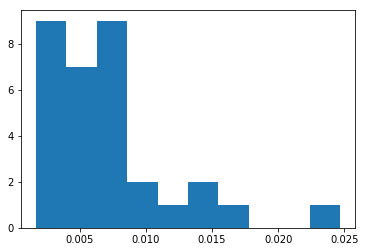

In [14]:
# Histogram of the ratio
plt.hist(scratchPadToTypingRatioTimeList)


In [ ]:
# userKeys = None
# scratchPad = None

# freqScratchPad = 0

# folder = r'C:\DTU\Data\201805_HealthnRehab\TypingData\May16\hc_MS\OptiKeyLogs\2018-5-16-13-42-4'
# for file in os.listdir(folder):

#     if fnmatch.fnmatchcase(file, 'user_looks_at_key*'):
#         try:
#             fUserKey = open(folder + '\\' + file, encoding='utf-8')
#             readerUserKey = csv.reader(fUserKey)
#             userKeys = list(readerUserKey)
#             userKeys.remove(userKeys[0])
                    
#         except:
#             if fUserKey is not None:
#                 fUserKey.close()
#             else:
#                 print('error in opening the user looks at file')
                        
#     elif fnmatch.fnmatch(file, 'ScratchPadLog*'):
#         try:                
#             fScratchPad = open(folder + '\\' + file, encoding='utf-8')
#             readerScratchPad = csv.reader(fScratchPad)
#             scratchPad = list(readerScratchPad)
#             scratchPad.remove(scratchPad[0])
#         except:
#             if fScratchPad is not None:
#                 fScratchPad.close()
#             else:
#                 print('error in opening the scratchpad log file')
                
#     else:
#         continue
    
#     # if all these lists exist:
#     if scratchPad and userKeys:

#         # Number of times scratchpad was looked at
        
#         freqScratchPad = UniqueGazeFreq(userKeys)
        
#         # Number of characters typed -- only the last phrase to be considered
#         nCharTyped = CharactersTyped(scratchPad)
        
#         nReadTextEventsPerChar = float(freqScratchPad/nCharTyped)
        
#         print(nReadTextEventsPerChar)

#         break
    